In [1]:
import os
import torch
import torchvision
from torchvision import datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt
import requests
from zipfile import ZipFile
from io import BytesIO
import numpy as np
import zipfile
import os


zip_file_path = r'C:\Users\nicol\Documents\PoliTo\AdvancedML\project\SPair-71k.zip' 
extract_dir = r'C:\Users\nicol\Documents\PoliTo\AdvancedML\project\SPair-71k_extracted'

# Crea la directory di estrazione se non esiste
os.makedirs(extract_dir, exist_ok=True)

# Estrai il file ZIP solo se esiste
if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"File '{zip_file_path}' estratto con successo nella directory '{extract_dir}'")
    print(f"Contenuti della directory '{extract_dir}':\n{os.listdir(extract_dir)}")
else:
    print(f"File zip '{zip_file_path}' non trovato. Assicurati che il dataset sia estratto in '{extract_dir}'.")



File 'C:\Users\nicol\Documents\PoliTo\AdvancedML\project\SPair-71k.zip' estratto con successo nella directory 'C:\Users\nicol\Documents\PoliTo\AdvancedML\project\SPair-71k_extracted'
Contenuti della directory 'C:\Users\nicol\Documents\PoliTo\AdvancedML\project\SPair-71k_extracted':
['SPair-71k']


In [2]:
import os
import glob
import json
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

# --- 1. Define the Augmentation Pipeline ---
def get_transforms(mode='train', img_size=518):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    if mode == 'train':
        return A.Compose([
            # Geometric Augmentations (Hard - Moves Keypoints)
            A.Resize(height=img_size, width=img_size), # Force DINOv2 size
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
            
            # Pixel Augmentations (Safe - Colors only)
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
            A.GaussianBlur(p=0.1),
            
            # Normalization & Conversion
            A.Normalize(mean=mean, std=std),
            ToTensorV2(), # Converts to (C, H, W)
        ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))
    
    else:
        # Validation/Test: Only Resize & Normalize
        return A.Compose([
            A.Resize(height=img_size, width=img_size),
            A.Normalize(mean=mean, std=std),
            ToTensorV2(),
        ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

# --- 2. Simple Image Reader ---
def read_img(path):
    # Keep as HWC (Standard for Albumentations)
    # Do not transpose or convert to Tensor here yet
    img = np.array(Image.open(path).convert('RGB'))
    return img

class SPairDataset(Dataset):
    def __init__(self, pair_ann_path, layout_path, image_path, dataset_size, pck_alpha, datatype):
        self.datatype = datatype
        self.pck_alpha = pck_alpha
        self.ann_files = open(os.path.join(layout_path, dataset_size, datatype + '.txt'), "r").read().split('\n')
        self.ann_files = [x for x in self.ann_files if x] # Remove empty strings
        self.pair_ann_path = pair_ann_path
        self.image_path = image_path
        
        # Initialize the Transform Pipeline
        mode = 'train' if datatype == 'trn' else 'test'
        self.transform = get_transforms(mode=mode, img_size=518)

    def __len__(self):
        return len(self.ann_files)

    def __getitem__(self, idx):
        raw_line = self.ann_files[idx]
        ann_filename = raw_line.replace(':', '_')
        ann_file = ann_filename + '.json'
        json_path = os.path.join(self.pair_ann_path, self.datatype, ann_file)

        with open(json_path) as f:
            annotation = json.load(f)

        category = annotation['category']
        src_path = os.path.join(self.image_path, category, annotation['src_imname'])
        trg_path = os.path.join(self.image_path, category, annotation['trg_imname'])

        # 1. Load Images
        src_img_raw = read_img(src_path)
        trg_img_raw = read_img(trg_path)

        # 2. Get Keypoints
        src_kps = np.array(annotation['src_kps']).astype(np.float32)
        trg_kps = np.array(annotation['trg_kps']).astype(np.float32)

        # 3. Apply Augmentations
        src_aug = self.transform(image=src_img_raw, keypoints=src_kps)
        src_tensor = src_aug['image']
        src_kps_aug = np.array(src_aug['keypoints'])
        
        trg_aug = self.transform(image=trg_img_raw, keypoints=trg_kps)
        trg_tensor = trg_aug['image']
        trg_kps_aug = np.array(trg_aug['keypoints'])

        # ==========================================================
        # ⚠️ CRITICAL FIX: PADDING LOGIC (Prevents Stack Error)
        # ==========================================================
        # We enforce a fixed size of 40 points per image.
        MAX_KPS = 40 
        
        # Create empty containers filled with zeros (Shape: [40, 2])
        src_kps_padded = np.zeros((MAX_KPS, 2), dtype=np.float32)
        trg_kps_padded = np.zeros((MAX_KPS, 2), dtype=np.float32)
        
        # Get the actual number of points (limit to 40 just in case)
        n_src = min(len(src_kps_aug), MAX_KPS)
        n_trg = min(len(trg_kps_aug), MAX_KPS)
        
        # Copy the real points into the empty container
        if n_src > 0:
            src_kps_padded[:n_src] = src_kps_aug[:n_src]
        if n_trg > 0:
            trg_kps_padded[:n_trg] = trg_kps_aug[:n_trg]

        # Check which points are inside the image (Visibility)
        src_vis = self._check_visibility(src_kps_padded, 518, 518)
        trg_vis = self._check_visibility(trg_kps_padded, 518, 518)
        
        # Create the Valid Mask
        # A point is valid ONLY if:
        # 1. It existed in the original file (index < n_src)
        # 2. It is still inside the image boundaries (vis=1)
        valid_mask = np.zeros(MAX_KPS, dtype=np.float32)
        
        # We assume points are ordered pairs (1st src matches 1st trg)
        # So we only mark as valid if BOTH exist and are visible
        common_len = min(n_src, n_trg)
        valid_mask[:common_len] = src_vis[:common_len] * trg_vis[:common_len]
        # ==========================================================

        pck_threshold = 518 * self.pck_alpha

        sample = {
            'pair_id': annotation['pair_id'],
            'src_img': src_tensor,
            'trg_img': trg_tensor,
            
            # Now these are ALWAYS [40, 2], so PyTorch won't crash!
            'src_kps': torch.from_numpy(src_kps_padded).float(), 
            'trg_kps': torch.from_numpy(trg_kps_padded).float(), 
            'valid_mask': torch.from_numpy(valid_mask).float(), 
            
            'pck_threshold': pck_threshold,
            'category': category
        }

        return sample

    def _check_visibility(self, kps, h, w):
        """Returns a binary mask (N,) where 1=visible, 0=out of bounds"""
        # kps is shape (N, 2) -> (x, y)
        x = kps[:, 0]
        y = kps[:, 1]
        
        # Check boundaries
        vis_x = (x >= 0) & (x < w)
        vis_y = (y >= 0) & (y < h)
        return (vis_x & vis_y).astype(np.float32)

if __name__ == '__main__':
    # Update this path to your actual path
    base_dir = r"C:\Users\nicol\Documents\PoliTo\AdvancedML\project\SPair-71k_extracted\SPair-71k\SPair-71k"    
    
    pair_ann_path = os.path.join(base_dir, 'PairAnnotation')
    layout_path = os.path.join(base_dir, 'Layout')
    image_path = os.path.join(base_dir, 'JPEGImages')

    # Check paths
    if os.path.exists(base_dir):
        
        # --- 1. Load TRAINING Set ---
        print("Loading Training Set...")
        trn_dataset = SPairDataset(
            pair_ann_path, layout_path, image_path, 
            dataset_size='large', pck_alpha=0.05, 
            datatype='trn'  # <--- Loads from trn.txt
        )
        # SHUFFLE = TRUE for training (important for learning)
        trn_loader = DataLoader(trn_dataset, batch_size=4, shuffle=True)


        # --- 2. Load VALIDATION Set ---
        print("Loading Validation Set...")
        val_dataset = SPairDataset(
            pair_ann_path, layout_path, image_path, 
            dataset_size='large', pck_alpha=0.05, 
            datatype='val'  # <--- Loads from val.txt
        )
        # SHUFFLE = FALSE for validation (keep order stable)
        val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

        
        # --- 3. Test Loading ---
        print("Testing batches...")
        
        # Grab a training batch
        trn_batch = next(iter(trn_loader))
        print(f"Train Batch Images: {trn_batch['src_img'].shape}")
        
        # Grab a validation batch
        val_batch = next(iter(val_loader))
        print(f"Val Batch Images:   {val_batch['src_img'].shape}")
        
        print("Dataset setup complete. Ready for Training Loop.")
        
    else:
        print(f"Path not found: {base_dir}")

Loading Training Set...
Loading Validation Set...
Testing batches...


c:\Users\nicol\anaconda3\envs\pytorch_env\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Train Batch Images: torch.Size([4, 3, 518, 518])
Val Batch Images:   torch.Size([4, 3, 518, 518])
Dataset setup complete. Ready for Training Loop.



--- Step 3: Learning Rate Sweep ---

>>> Testing LR: 0.001 ...


Using cache found in C:\Users\nicol/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\nicol/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\nicol/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\nicol/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


   Step 0: Loss 5.4048
   Step 20: Loss 4.9842
   Step 40: Loss 5.4876
   Step 60: Loss 4.6971
   Step 80: Loss 4.9320

>>> Testing LR: 0.0005 ...


Using cache found in C:\Users\nicol/.cache\torch\hub\facebookresearch_dinov2_main


   Step 0: Loss 4.0487
   Step 20: Loss 3.7043
   Step 40: Loss 5.3559
   Step 60: Loss 4.8596
   Step 80: Loss 3.3422

>>> Testing LR: 0.0001 ...


Using cache found in C:\Users\nicol/.cache\torch\hub\facebookresearch_dinov2_main


   Step 0: Loss 5.2873
   Step 20: Loss 3.4927
   Step 40: Loss 4.6082
   Step 60: Loss 4.1069
   Step 80: Loss 4.1892

>>> Testing LR: 5e-05 ...


Using cache found in C:\Users\nicol/.cache\torch\hub\facebookresearch_dinov2_main


   Step 0: Loss 4.6907
   Step 20: Loss 3.9775
   Step 40: Loss 3.1667
   Step 60: Loss 2.9436
   Step 80: Loss 2.7699

--- Sweep Complete. Analysis: ---
LR 0.001: Final Loss = 5.3421
LR 0.0005: Final Loss = 4.0734
LR 0.0001: Final Loss = 3.4693
LR 5e-05: Final Loss = 3.3817


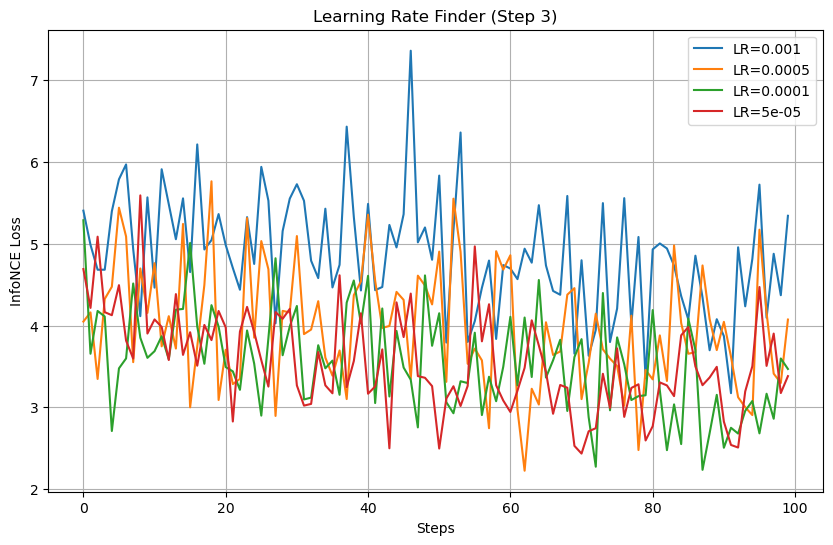

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

# ==========================================
# 1. HELPER FUNCTIONS (From Step 2)
# ==========================================

def get_patch_indices(keypoints, img_size=518, patch_size=14):
    """
    Converts (x, y) pixel coordinates into the index of the patch (0 to 1368).
    keypoints: [Batch, N_kps, 2]
    """
    grid_w = img_size // patch_size # 37
    
    # Scale coordinates to grid integers (0..36)
    grid_x = (keypoints[:, :, 0] / patch_size).long().clamp(0, grid_w-1)
    grid_y = (keypoints[:, :, 1] / patch_size).long().clamp(0, grid_w-1)
    
    # Calculate flat index (y * width + x)
    flat_indices = grid_y * grid_w + grid_x  # [Batch, N_kps]
    return flat_indices

def extract_features_at_indices(features, indices):
    """
    features: [Batch, 1369, Dim]
    indices:  [Batch, N_kps]
    Returns:  [Batch, N_kps, Dim]
    """
    B, N_patches, Dim = features.shape
    B, N_kps = indices.shape
    
    # Expand indices to gather across the Dim dimension
    # [B, N_kps] -> [B, N_kps, Dim]
    indices_expanded = indices.unsqueeze(-1).expand(-1, -1, Dim)
    
    # Gather specific features
    kps_features = torch.gather(features, 1, indices_expanded)
    return kps_features

def contrastive_loss(feat_src_kps, feat_trg_all, trg_kps_indices, mask, temp=0.1):
    """
    InfoNCE Loss specific for Keypoint Matching.
    """
    # Normalize features
    feat_src_kps = F.normalize(feat_src_kps, dim=-1)
    feat_trg_all = F.normalize(feat_trg_all, dim=-1)
    
    # Similarity: [B, N, Dim] @ [B, Dim, 1369] -> [B, N, 1369]
    logits = torch.bmm(feat_src_kps, feat_trg_all.transpose(1, 2)) / temp
    
    # Flatten everything to 2D for CrossEntropy
    valid = mask.bool()
    
    logits_valid = logits[valid]       # [Total_Valid_Kps, 1369]
    targets_valid = trg_kps_indices[valid] # [Total_Valid_Kps]
    
    loss = F.cross_entropy(logits_valid, targets_valid)
    return loss

# ==========================================
# 2. MAIN SWEEP EXECUTION (Step 3)
# ==========================================

if __name__ == "__main__":
    # --- Configurations ---
    lrs_to_test = [1e-3, 5e-4, 1e-4, 5e-5]
    steps_per_lr = 100

    # Store results to plot later
    results = {}

    print("\n--- Step 3: Learning Rate Sweep ---")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Ensure trn_loader exists
    try:
        _ = len(trn_loader)
    except NameError:
        print("Error: trn_loader not defined. Please run your dataset setup code first.")
        exit()

    for lr in lrs_to_test:
        print(f"\n>>> Testing LR: {lr} ...")
        
        # 1. RESET Model for every LR (Crucial!)
        # We reload fresh weights to ensure previous runs don't affect this one
        model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14').to(device)
        
        # Freeze / Unfreeze Logic (Last 2 Blocks)
        for param in model.parameters(): param.requires_grad = False
        for block in model.blocks[-2:]: 
            for param in block.parameters(): param.requires_grad = True
                
        # 2. Setup Optimizer (With Weight Decay now!)
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), 
                                lr=lr, weight_decay=1e-4)
        
        model.train()
        losses = []
        
        # 3. Train for 100 steps
        for i, batch in enumerate(trn_loader):
            if i >= steps_per_lr: break # Stop after 100 steps
            
            # Load Data
            src = batch['src_img'].to(device)
            trg = batch['trg_img'].to(device)
            src_kps = batch['src_kps'].to(device)
            trg_kps = batch['trg_kps'].to(device)
            mask    = batch['valid_mask'].to(device)
            
            # Pre-calc indices (Using the helpers defined above!)
            src_indices = get_patch_indices(src_kps)
            trg_indices = get_patch_indices(trg_kps)

            optimizer.zero_grad()
            
            # Forward
            dict_A = model.forward_features(src)
            dict_B = model.forward_features(trg)
            
            feat_A_kps = extract_features_at_indices(dict_A['x_norm_patchtokens'], src_indices)
            feat_B_all = dict_B['x_norm_patchtokens']
            
            # Loss
            loss = contrastive_loss(feat_A_kps, feat_B_all, trg_indices, mask)
            
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            
            if i % 20 == 0:
                print(f"   Step {i}: Loss {loss.item():.4f}")
                
        results[lr] = losses

    # --- 4. Visualize Results ---
    print("\n--- Sweep Complete. Analysis: ---")
    plt.figure(figsize=(10, 6))
    for lr, loss_curve in results.items():
        plt.plot(loss_curve, label=f"LR={lr}")
        print(f"LR {lr}: Final Loss = {loss_curve[-1]:.4f}")

    plt.xlabel("Steps")
    plt.ylabel("InfoNCE Loss")
    plt.title("Learning Rate Finder (Step 3)")
    plt.legend()
    plt.grid(True)
    plt.show()